# Inferences

I'm going to keep track of model progress in this notebook. After X number of steps, I will extract inferences and view the predictions. 

In [29]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
import glob
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
tf.__version__

'2.2.0'

# 10000 steps of training

In [3]:
INPUT_PATH = "./global-wheat-detection"

inferences = tf.data.TFRecordDataset(os.path.join(INPUT_PATH, "inferences.tfrecord"))

In [14]:
detections = pd.DataFrame(columns=['score', 'label_idx', 'xmin', 'xmax', 'ymin', 'ymax', 'filename'])

example = tf.train.Example()

for record in tf.compat.v1.io.tf_record_iterator(os.path.join(INPUT_PATH, "inferences.tfrecord")):
    
    example.ParseFromString(record)
    
    f = example.features.feature
    
    score = f['image/detection/score'].float_list.value
    
    score = [x for x in score if x >= 0.60]
    
    l = len(score)
    
    detections = detections.append({'score': score,
                                    
                    'label_idx': f['image/detection/label'].int64_list.value[:l],
                                    
                    'xmin': f['image/detection/bbox/xmin'].float_list.value[:l],
                                    
                    'xmax': f['image/detection/bbox/xmax'].float_list.value[:l],
                                    
                    'ymin': f['image/detection/bbox/ymin'].float_list.value[:l],
                                    
                    'ymax': f['image/detection/bbox/ymax'].float_list.value[:l],
                                    
                    'filename': f['image/filename'].bytes_list.value[0].decode()}, ignore_index=True)

In [15]:
converted_obs = []

for i in range(len(detections)):
    
    for j in range(len(detections.iloc[i]["score"])):
        
        d = {}
        
        d["filename"] = detections.iloc[i]["filename"]
        
        d["score"] = detections.iloc[i]["score"][j]
        
        d["xmin"] = detections.iloc[i]["xmin"][j]
        
        d["xmax"] = detections.iloc[i]["xmax"][j]
        
        d["ymin"] = detections.iloc[i]["ymin"][j]
        
        d["ymax"] = detections.iloc[i]["ymax"][j]
        
        converted_obs.append(d)

In [18]:
inferences = pd.DataFrame(converted_obs)

In [33]:
def rescale(x, scalar):
    
    return(int(x * scalar))

In [36]:
inferences["ymin"] = inferences.ymin.apply(lambda x: rescale(x, 1024))

inferences["ymax"] = inferences.ymax.apply(lambda x: rescale(x, 1024))

inferences["xmin"] = inferences.xmin.apply(lambda x: rescale(x, 1024))

inferences["xmax"] = inferences.xmax.apply(lambda x: rescale(x, 1024))

In [43]:
inferences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 6 columns):
filename    723 non-null object
score       723 non-null float64
xmax        723 non-null int64
xmin        723 non-null int64
ymax        723 non-null int64
ymin        723 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 34.0+ KB


In [59]:
def plot_tensors(df: pd.DataFrame, file: str, input_dir: str):
    
    fig, ax = plt.subplots(figsize = (12, 12))
        
    partial = df[df.filename == file].reset_index(drop = True)

    with tf.io.gfile.GFile(os.path.join(input_dir, file), "rb") as f:

        encoded = f.read()

    img = Image.open(BytesIO(encoded))

    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    for _, row in partial.iterrows():
        
        cv2.rectangle(img_cv, (row.xmin, row.ymin), (row.xmax, row.ymax), (255, 0, 0), 2)

    ax.set_axis_off()

    ax.imshow(img_cv)

    ax.set_title(f"Sample Image {i}")

In [60]:
all_files = list(inferences.filename.unique())

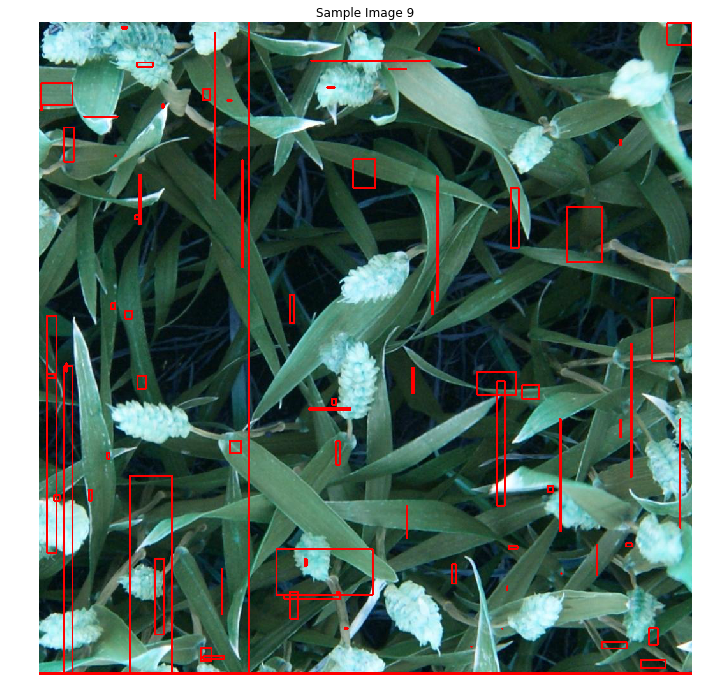

In [61]:
input_dir = "./global-wheat-detection/test"

plot_tensors(inferences, all_files[0], input_dir)

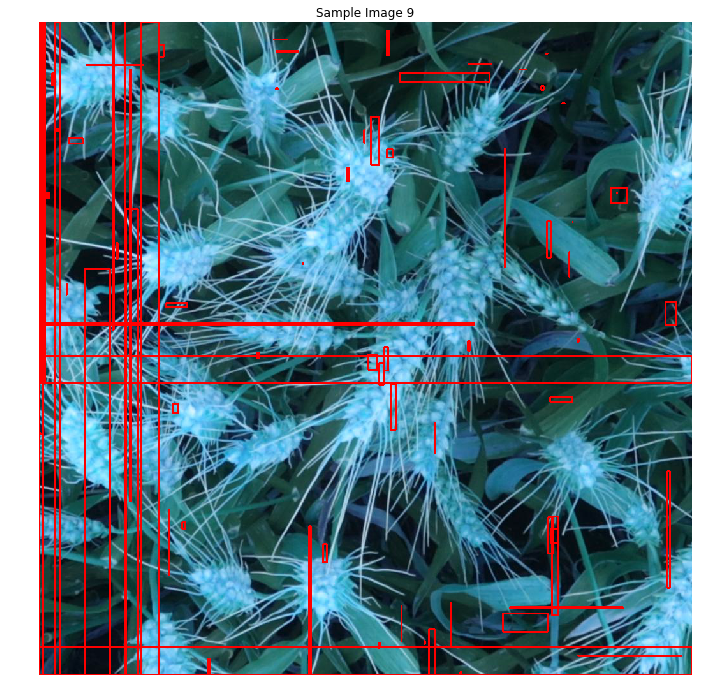

In [62]:
plot_tensors(inferences, all_files[1], input_dir)

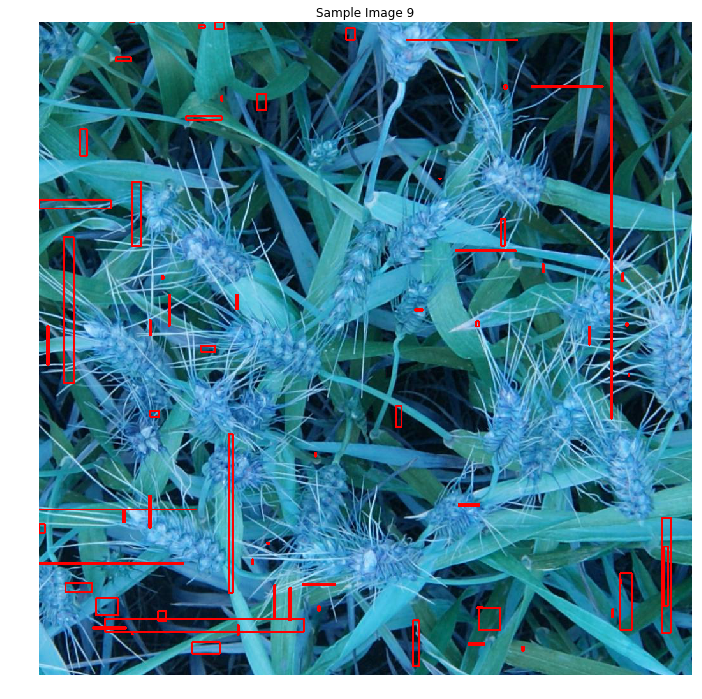

In [63]:
plot_tensors(inferences, all_files[2], input_dir)

These are terrible. Obviously we need more training.